## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 6: MCMC

### Michael Struk

In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

## Tasks


1. Write the `logLikelihood` and `logPosterior` functions for the above distribution, choosing appropriately wide priors. An example of coding the multivariate Gaussian is in class notebook for Week 9.<br>

In [2]:
# Define the means
mu1 = np.array([-3.0, -3.0, -3.0])
mu2 = np.array([1.0, 1.0, 1.0])
mu3 = np.array([0.0, 0.0, 0.0])

# Define the covariance matrices
sigma1 = np.array([[1.0, 0.9, 0.0], [0.9, 1.0, 0.0], [0.0, 0.0, 1.0]])
sigma2 = np.array([[0.25, 0.1, 0.0], [0.1, 0.25, 0.0], [0.0, 0.0, 0.25]])
sigma3 = np.array([[0.25, -0.1, 0.0], [-0.1, 0.25, 0.0], [0.0, 0.0, 0.25]])

# Define the inverse covariance matrices
inv1 = np.linalg.inv(sigma1)
inv2 = np.linalg.inv(sigma2)
inv3 = np.linalg.inv(sigma3)

# Define the covariance matrix determinants
det1 = np.linalg.det(sigma1)
det2 = np.linalg.det(sigma2)
det3 = np.linalg.det(sigma3)

def logLikelihood(p):
    k = len(p) # dimension
    
    # target component
    diff1 = p - mu1
    LL1 = -0.5*np.dot(diff1, np.dot(inv1, diff1)) - 0.5*np.log(det1) - 0.5*k*np.log(2*np.pi)
    
    # noise components
    diff2 = p - mu2
    LL2 = -0.5*np.dot(diff2, np.dot(inv2, diff2)) - 0.5*np.log(det2) - 0.5*k*np.log(2*np.pi)
    
    diff3 = p - mu3
    LL3 = -0.5*np.dot(diff3, np.dot(inv3, diff3)) - 0.5*np.log(det3) - 0.5*k*np.log(2*np.pi)
    
    # Combine log likelihoods
    return np.log(np.exp(LL1) + 0.01 * (np.exp(LL2) + np.exp(LL3)))

def logPrior(p):
    if np.all((-25 < p) & (p < 25)):
        return 0.0
    else:
        return -np.inf

def logPosterior(p):
    return logPrior(p) + logLikelihood(p)


* Definitions of
    * the target parameters, the noise components, and the covariance matrices for each
    * the inverses and determinants of each covariance matrix for likelihood function
    * the log likelihood, log prior (appropriately wide), and log posterior functions.

2. Run direct maximization of the likelihood with Scipy as in previous projects. Does it recover the target parameters $\boldsymbol\mu_1$ and $\mathbf{\Sigma}_1$?<br>


In [3]:
from scipy import optimize

o = optimize.minimize(lambda p: -logLikelihood(p), np.array([-1,0,-1.5])) # use lambda function to minimize negative log likelihood

print(f"Maximization results:\n --> recovered parameters {o.x} \n--> with covariance matrix\n {o.hess_inv}")
print("\nExpected target parameters mu1:", mu1)
print("Expected covariance matrix Sigma1:\n", sigma1)

Maximization results:
 --> recovered parameters [-2.99999987 -2.9999992  -2.99999808] 
--> with covariance matrix
 [[0.99513182 0.8973872  0.01339603]
 [0.8973872  1.00400203 0.02491096]
 [0.01339603 0.02491096 1.02111543]]

Expected target parameters mu1: [-3. -3. -3.]
Expected covariance matrix Sigma1:
 [[1.  0.9 0. ]
 [0.9 1.  0. ]
 [0.  0.  1. ]]


* Maximization of the logLikelihood function through minimization of the negative logLikelihood, using the lambda function to define the negative.
* The optimized parameters $p \pm \text{var}(p) = -2.99\pm0.99, -2.99\pm1.004,\;\text{and}\;  -2.99\pm1.02$ are recovered in accordance with the expected $p \pm \text{var}(p) = -3.0\pm1.0, -3.0\pm1.0,\;\text{and}\;  -3.0\pm1.0$ for $p[i=0,1,2]$. The off-diagonal correlations $0.897$ and $0.897$ are also nearly identical to the expected $0.9$ and $0.9$.

3. Initialize the `emcee` sampler in random locations for 100 walkers. Run it for at least 500 steps to get preliminary estimates of the autocorrelation time and parameter values. Compare the means, standard deviations, and the correlation coefficient of the first two parameters with the target.<br>


In [4]:
# initialize number of parameter dimensions and walkers
ndim = 3
nwalkers = 100

# run for 500 steps to get preliminary estimates
nsteps = 500

np.random.seed(0) # intialize the RNG for reproducible results


############## Sampling for mu1 ##############

# choose initial set of positions for the walkers
p = np.array([-3, -3, -3])
p0 = [p + 0.1*np.random.rand(ndim) for i in range(nwalkers)] # random initial locations for walkers 

# initialize the sampler with the chosen specs above
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)

# run sampling
sampler.run_mcmc(p0, nsteps)

# results
init_samples = sampler.flatchain
mean_params = np.mean(init_samples, axis=0)
std_params = np.std(init_samples, axis=0)
corr = np.corrcoef(init_samples[:, 0], init_samples[:, 1])[0, 1]
acorrt = [int(sampler.get_autocorr_time(tol=10)[i]) for i in [0,1,2]]

print(f"p[i=0,1] estimates: \ni=0 {mean_params[0]:.3f}+/-{std_params[0]:.3f}\ni=1 {mean_params[1]:.3f}+/-{std_params[1]:.3f}")
print(f"correlation = {corr: .3f}")
print(f'\n---> expected i=0 {mu1[0]:.3f}+/-{sigma1[0,0]:.3f}\n              i=1 {mu1[1]:.3f}+/-{sigma1[1,1]:.3f}\n              correlation = 0.9')
print(f"\nautocorrelation times for p[i=0,1] = {acorrt[:2]}")
print()
##################################################

p[i=0,1] estimates: 
i=0 -2.961+/-1.086
i=1 -2.963+/-1.078
correlation =  0.911

---> expected i=0 -3.000+/-1.000
              i=1 -3.000+/-1.000
              correlation = 0.9

autocorrelation times for p[i=0,1] = [24, 24]



* As printed above, the estimated means, within the standard deviations, agree with the expected values. The standard deviations and correlations themselves are also in agreement.
* Autocorrelation times for the first two target parameters are also printed, and are both $24$ steps.


4. Run an additional required number of __burn-in__ steps, based on the first estimate of $N_{corr}\;$. Using this chain, update an estimate of $N_{corr}\;$ and the parameter values. Then reset the chain, discarding the burn-in samples but keeping the `state` of the sampler.<br>


In [5]:
# intended burn in steps based on mu1 autocorrelation time
nburn = acorrt[0] * 10

# run burn in sampling
pos, prob, state = sampler.run_mcmc(p0, nburn) # save the state of sampler after burn sampling

# reset chain to discard burn-in samples
sampler.reset()

5. Now run the sampler until the __mean__ and __standard deviation__ of each parameter individually converge to 1% relative accuracy. Do it in chunks of steps of length $10 N_{corr}\;$. After each chunk, keep updating the value of $N_{corr}\;$. Calculate the parameter values using the appropriately __thinned__ chain.<br>


In [6]:
# initialize means and stds for looping
pmean = np.zeros(ndim)
pstd = np.zeros(ndim)
# intitialize convergence criterion
not_converged = True 
# initialize counter
nchain = 0 
# intitialize ncorr for step chunk 
ncorr = acorrt[0]

while not_converged:
    
    # starting from the last position in the chain, sample nsteps
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)

    # work in step chunks of length 10*N_corr
    nchain += 10*ncorr
    
    acorr = sampler.get_autocorr_time(tol=10) # autocorrelation time for all parameters
    ncorr = int(acorr[0])                     # choose a single integer value

    # mean values of the parameters
    pmean_last = np.copy(pmean) # np.copy will reassign pmean_last to pmean from the previous loop before it's redefined
    pmean = np.mean(sampler.flatchain[::ncorr], axis=0)

    # std values of the parameters
    pstd_last = np.copy(pstd)
    pstd = np.std(sampler.flatchain[::ncorr], axis=0)
    
    # convergence criterion
    if nchain > (10*ncorr): # dont check on first realization to avoid divide by 0
        if ((abs((pmean[0]-pmean_last[0]) / pmean_last[0]) < 0.01) & (abs((pstd[0]-pstd_last[0]) / pstd_last[0]) < 0.01)):
            not_converged = False


/var/folders/y3/_hj0h0sd6b1811vf6kl003g40000gn/T/ipykernel_87743/3938090019.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  if ((abs((pmean[0]-pmean_last[0]) / pmean_last[0]) < 0.01) & (abs((pstd[0]-pstd_last[0]) / pstd_last[0]) < 0.01)):


6. Plot the first few hundred steps of the new chain and check that the estimated value of $N_{corr}\;$ corresponds to a visible correlation between the sequential values of all three parameters. Which parameter has the largest $N_{corr}\;$?<br>

Ncorr[0] = 29
Ncorr[1] = 28
Ncorr[2] = 29


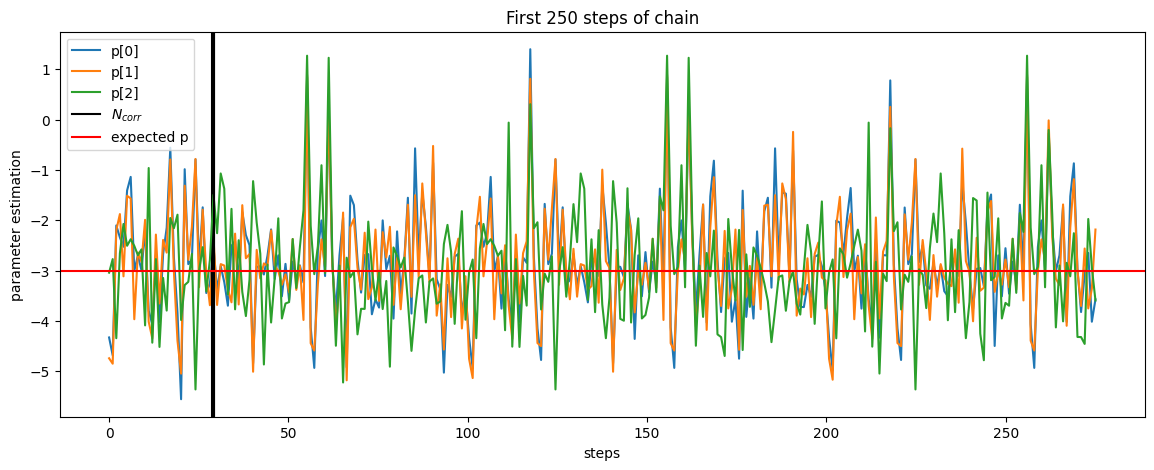

In [7]:
# number of points to plot from chain
npoints = 275

# Plotting points
xx = np.linspace(0, npoints, npoints)

plt.figure(figsize=(14,5))

# Taking the first npoints from each parameter chain
samples = []
for i in [0,1,2]:
    samples.append(sampler.flatchain[:npoints, i])

# Plotting and getting autocorrelation times
for j in [0,1,2]:
    plt.plot(xx, samples[j], label=f"p[{j}]")
    plt.axvline(sampler.get_autocorr_time(tol=10)[j], c='k')
    print(f"Ncorr[{j}] = {int(sampler.get_autocorr_time(tol=10)[j])}")
plt.axvline(sampler.get_autocorr_time(tol=10)[2], c='k', label=r'$N_{corr}$')

plt.axhline(-3, c='r', label='expected p')
plt.xlabel('steps')
plt.ylabel('parameter estimation')
plt.title('First 250 steps of chain')
plt.legend()
plt.show()


* This plot shows how the parameter distributions vary throughout the steps in their chains. The expected value for each of them of $-3$ is clearly displayed, and all of them average out to around there. In terms of a Gaussian distribution, visually, the mean of each sits around $-3$, and the scatter or $\sigma$ is about $\pm1$, as expected.
* The $N_{corr}$ for each is also plotted, where $N_{corr}[0,1,2]=[29,28,29]$, meaning $i=0,2$ had the highest values, though these are rounded integer values and are effectively the same.
* The parameter values throughout the chain do appear to have 'forgotten' their previous locations and correlate after $N_{corr}$ steps, as there is a definite pattern that repeats every ~100 steps after that point. 

7. Use the `corner` routine to plot the thinned chain. Do the estimated parameter values correspond to the target?<br>



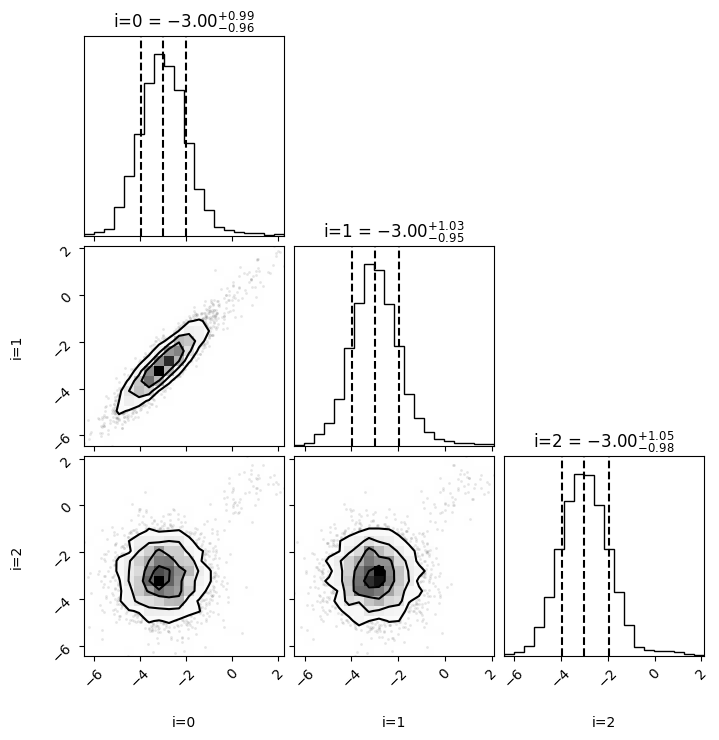

In [8]:
corner.corner(sampler.flatchain[::ncorr], labels=['i=0', 'i=1', 'i=2'],\
              quantiles=[0.16, 0.5, 0.84], show_titles=True);

* From this corner plot, the MCMC estimated parameter values do correspond extremely well to their targets.
* Estimated $p=[-3.00,-3.00,-3.00]$, each with plus-minus errors of approximately $\pm1$, where we expected the same.

8. Plot the distribution of the first parameter from the thinned chain, using KDE. Superimpose the Gaussian distribution with the calculated mean and standard deviation, and the Gaussian corresponding to the target distribution. Is there a good match?

In [9]:
# Epanechnikov kernel
def k_E(u):
    k = 0.75*(1.-u**2)
    k[k<0] = 0
    return k


def kde(Xdata, Xgrid, h=None, hmin=None, norm=True, kernel=k_E):
    
    # find optimum bandwidth
    if h is None:
        IQR = np.percentile(Xdata,75) - np.percentile(Xdata,25)
        hh = min(np.std(Xdata),IQR/1.34) * 0.9/len(Xdata)**0.2
    else:
        hh = np.copy(h)
    
    # enforce minimum bandwidth
    if hmin is not None:
        if np.ndim(hh) > 0:
            print('kde: increased width to %g for %d of %d data' % (hmin,sum(hh < hmin),len(hh)))
            hh[hh < hmin] = hmin
        else:
            if hh < hmin:
                print('kde: width h_opt = %g increased to %g' % (hh,hmin))
                hh = hmin
        
    k = np.array([ np.sum( kernel((x-Xdata)/hh) / hh ) for x in Xgrid ])
    
    if norm:
        k = k/len(Xdata)

    return k

# Gaussian function
def gauss(x, b, mu, sigma):
    return b*np.exp(-(x-mu)**2/(2*(sigma**2)))

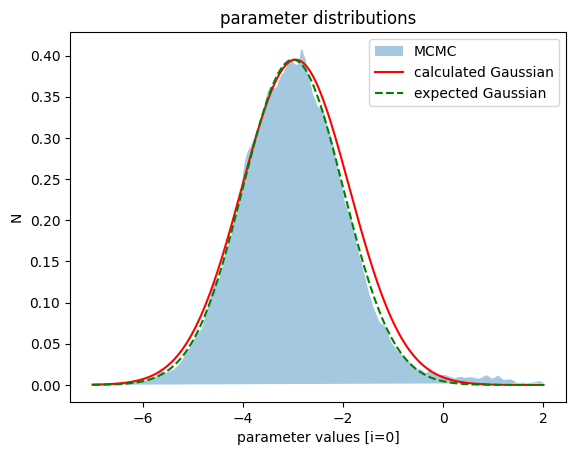

In [10]:
# KDE
xx = np.linspace(-7, 2, 500)
plt.fill(xx, kde(np.array(sampler.flatchain[:,0]), xx), alpha=0.4, label='MCMC')

# Gaussian curves
plt.plot(xx, gauss(xx, 0.395, pmean[0], pstd[0]), c='r', label='calculated Gaussian')
plt.plot(xx, gauss(xx, 0.395, -3, 1), ls='dashed', c='g', label='expected Gaussian')

plt.xlabel('parameter values [i=0]')
plt.ylabel('N')
plt.title('parameter distributions')
plt.legend()
plt.show()

* The Epanechnikov kernel KDE, Gaussian from estimated parameters, and Gaussian from expected parameters, match up quite nicely with high amounts of overlap. The Gaussian curves wrap the area filled by the KDE almost exactly.

## Analysis
* Which numerical methods worked or did not work in this project
    * The Bayesian methods using logs of likelihood, prior, and posterior probabilities worked well with emcee's instance of MCMC, providing almost exact estimations of the target parameters, covariances, and correlations.
    * The maximization of the log likelihood worked equivalently to MCMC.
    * The estimated autocorrelation times were useful for sampling chunks along the chains for reaching numerical convergence of 1%.
    * The Epanechnikov KDE was a useful visualization of the parameter distribution obtained from sampling.
* Lessons learned
    * I was able to deepen my understanding of the process of initial sampling and using a burn-in to save the state of the sampler and continue until convergence.
    * I got to experience how different autocorrelation times and sampling chunk sizes affect the rate and level of convergence.
    * I worked to understand how the noise terms in the likelihood definition affected the problem (minimally due to the 1% weighting factor), and what parameters were important to focus on
* Further code improvements you could make with significantly more effort
    * I would've liked to continue messing with the burned samples, with visualization of how the old positions are 'forgotten' and watch the parameters converge in more detail.
    * I would've liked to adjust the original parameters and correlations to see how the chain reacted, i.e. test for robustness
    * I would've liked to change the autocorrelation time by hand to see how convergence is affected based on what sampling parameters are used
